In [1]:
import os
import gc
from tqdm import tqdm
import glob
import random
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import pdb
import datetime
from scipy import interpolate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
print('pandas ver : ' + pd.__version__)
print('numpy ver : ' + np.__version__)
print('sklearn ver : ' + sklearn.__version__)
print('prophet ver :' + torch.__version__)

pandas ver : 1.5.3
numpy ver : 1.23.2
sklearn ver : 1.2.2
prophet ver :2.0.0


In [3]:
INPUT_TIMESTEP = 48
OUTPUT_TIMESTEP = 72
TEACHER_FORCING_RATIO = 0.5
NaN_THRESHOLD = 1
EPOCHS = 100
LR = 1e-3
BS = 64
SEED = 42
ALPHA = 0.3
MODEL_NAME ='XGBoost_ver_1'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [4]:
device = torch.device('cpu') if torch.backends.mps.is_available() else torch.device('cpu')
#torch.autograd.set_detect_anomaly(False)
print(device)

cpu


# AWSmap pmmap

In [5]:
awsmap = pd.read_csv('./data/META/awsmap.csv')
pmmap = pd.read_csv('./data/META/pmmap.csv')

In [6]:
pmmap

,Location,Latitude,Longitude,Description
0,아름동,36.512252,127.246789,세종특별자치시 보듬3로 114 아름동커뮤니티센터 옥상 (아름동)
1,신흥동,36.592887,127.292550,세종 조치원읍 군청로 87-16(신흥동) 세종특별자치시 조치원청사 옥상
2,노은동,36.368242,127.318498,대전 유성구 노은동로 87번길 89(노은1동 주민센터) 노은1동 주민센터 3층 옥상
3,문창동,36.317215,127.437825,대전 중구 보문로 20번길 38(문창동 주민센터) 문창동 주민센터
4,읍내동,36.372388,127.417714,대전 대덕구 대전로 1331번길 75(태아산업(주)) 태아산업(주)
5,정림동,36.304442,127.366742,대전 서구 정림동로 10(정림동 주민센터) 정림동 주민센터
6,공주,36.446951,127.119209,충남 공주시 봉황로 1 (공주시의회 옥상)
7,논산,36.199217,127.087021,충남 논산시 시민로 389 (취암/부창동 행정복지센터 2층 옥상)
8,대천2동,36.353148,126.589735,충남 보령시 중앙로 142-16 (대천2동 주민센터 옥상)
9,독곶리,36.987579,126.391672,충남 서산시 대산읍 평신1로(독곶리) 한국수자원공사 대산산업용수센터 저수동 옥상


In [55]:
awsmap

,Location,Latitude,Longitude,Description
0,오월드,36.2913,127.3959,대전광역시 중구사정공원로 70 오월드 내 플라워랜드
1,세천,36.3402,127.4938,대전광역시 동구세천동 63-1
2,장동,36.4135,127.4382,대전광역시 대덕구장동 360-2
3,세종고운,36.5315,127.2406,세종특별자치시 고운동산 25번지
4,세종금남,36.4585,127.2688,세종특별자치시 시군구금남면 성덕리 77-3
5,세종연서,36.5667,127.2806,세종특별자치시 연서면봉암리 196-1
6,세종전의,36.6908,127.2005,세종특별자치시 전의면읍내리 5-1번지(전의생활체육공원)
7,북격렬비도,36.6254,125.5595,충청남도 태안군근흥면 가의도리산 27(북격렬비도)
8,호도,36.3012,126.2663,충청남도 보령시오천면 녹도리 388-5
9,대산,37.0106,126.3881,충청남도 서산시대산읍 대죽리산95-1 (5304부대 대산방공진지)


## Scatter plot

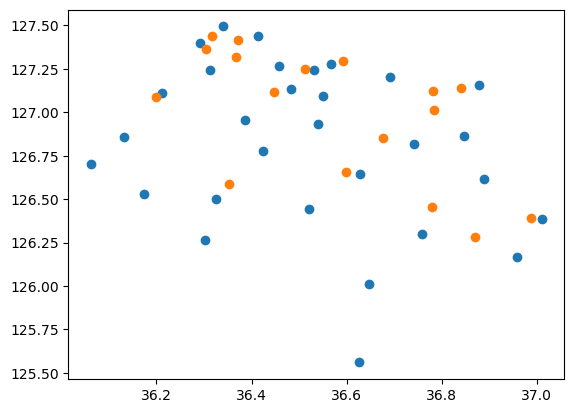

In [7]:
plt.scatter(awsmap['Latitude'], awsmap['Longitude'])
plt.scatter(pmmap['Latitude'], pmmap['Longitude'])
plt.show()

## Calculate distance

In [8]:
pm_cood = pmmap[['Location','Latitude','Longitude']]
aws_cood = awsmap[['Location','Latitude','Longitude']]

In [9]:
distance_list = []
location_list = []
for i in range(len(pm_cood)):
    min_distance = 1000000000
    location = None
    pm_lat = pm_cood['Latitude'][i]
    pm_lon = pm_cood['Longitude'][i]
    for j in range(len(aws_cood)):
        aws_lat = aws_cood['Latitude'][j]
        aws_lon = aws_cood['Longitude'][j]
        distance = math.sqrt((pm_lat-aws_lat)**2 + (pm_lon-aws_lon)**2)
        if min_distance > distance:
            min_distance = distance
            location = aws_cood['Location'][j]
    distance_list.append(min_distance)
    location_list.append(location)

In [10]:
print(location_list)

['세종고운', '세종연서', '계룡', '오월드', '장동', '오월드', '공주', '논산', '대천항', '대산', '태안', '아산', '성거', '예산', '태안', '홍북', '성거']


# Concatenate PM and AWS

In [11]:
pm_csv_list = sorted(glob.glob('./data/TRAIN/*'))
pm_csv_list

['./data/TRAIN/공주.csv',
 './data/TRAIN/노은동.csv',
 './data/TRAIN/논산.csv',
 './data/TRAIN/대천2동.csv',
 './data/TRAIN/독곶리.csv',
 './data/TRAIN/동문동.csv',
 './data/TRAIN/모종동.csv',
 './data/TRAIN/문창동.csv',
 './data/TRAIN/성성동.csv',
 './data/TRAIN/신방동.csv',
 './data/TRAIN/신흥동.csv',
 './data/TRAIN/아름동.csv',
 './data/TRAIN/예산군.csv',
 './data/TRAIN/읍내동.csv',
 './data/TRAIN/이원면.csv',
 './data/TRAIN/정림동.csv',
 './data/TRAIN/홍성읍.csv']

In [14]:
aws_basepath = './data/TRAIN_AWS/'
data = []
for idx, pm_path in enumerate(pm_csv_list):
    aws_path = './data/TRAIN_AWS/'+location_list[idx]+'.csv'
    pm_data = pd.read_csv(pm_path)
    aws_data = pd.read_csv(aws_path)
    #print(pm_data)
    #print(aws_data)
    aws_data['PM2.5'] = pm_data['PM2.5']
    time = []
    for i in range(len(aws_data)):
        time.append(datetime.datetime(2010+aws_data['연도'][i], int(aws_data['일시'][0][0:2]), 
                                             int(aws_data['일시'][i][3:5]), int(aws_data['일시'][i][6:8]), int(aws_data['일시'][i][9:])))
    aws_data['time'] = time
    #aws_data['기온(°C)'].interpolate(method='cubic', inplace=True)
    #aws_data['풍향(deg)'].interpolate(method='cubic', inplace=True)
    #aws_data['풍속(m/s)'].interpolate(method='cubic', inplace=True)
    #ws_data['강수량(mm)'].interpolate(method='cubic', inplace=True)
    #aws_data['습도(%)'].interpolate(method='cubic', inplace=True)
    #aws_data['PM2.5'].interpolate(method='cubic', inplace=True)
    
    #aws_data.dropna(axis=0,inplace=True)
    
    aws_data.drop(['연도', '일시', '지점'], axis=1, inplace=True)
    
    
    aws_data = aws_data[['time','기온(°C)','풍속(m/s)','강수량(mm)','습도(%)','PM2.5']]
    data.append(aws_data)

    #print(aws_data)

In [15]:
for i in range(len(data)):
    print(data[i].isnull().sum())
    print(data[i].isnull().values.any())

time         0
기온(°C)     300
풍속(m/s)    300
강수량(mm)    300
습도(%)      300
PM2.5      770
dtype: int64
True
time         0
기온(°C)     478
풍속(m/s)    478
강수량(mm)    478
습도(%)      478
PM2.5      924
dtype: int64
True
time          0
기온(°C)     1064
풍속(m/s)    1064
강수량(mm)    1064
습도(%)      1064
PM2.5      1187
dtype: int64
True
time         0
기온(°C)     471
풍속(m/s)    471
강수량(mm)    471
습도(%)      471
PM2.5      706
dtype: int64
True
time          0
기온(°C)      840
풍속(m/s)     840
강수량(mm)     840
습도(%)       840
PM2.5      1031
dtype: int64
True
time          0
기온(°C)      471
풍속(m/s)     471
강수량(mm)     471
습도(%)       471
PM2.5      2455
dtype: int64
True
time          0
기온(°C)      684
풍속(m/s)     684
강수량(mm)     684
습도(%)       684
PM2.5      1049
dtype: int64
True
time         0
기온(°C)     488
풍속(m/s)    488
강수량(mm)    488
습도(%)      488
PM2.5      636
dtype: int64
True
time         0
기온(°C)     455
풍속(m/s)    455
강수량(mm)    455
습도(%)      455
PM2.5      805
dtype: int64
True
time

In [18]:
def make_data(df):
    seed_everything(SEED) 
    df = df.drop('time',axis=1)
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    print(len(df))
    for i in range(len(df)-INPUT_TIMESTEP-OUTPUT_TIMESTEP+1):
        rand = random.randrange(1,100)
        if rand > 15:
            data_x = df[:][i:i+INPUT_TIMESTEP]
            data_y = df['PM2.5'][i+INPUT_TIMESTEP:i+INPUT_TIMESTEP+OUTPUT_TIMESTEP]
            if data_x.shape[0] - data_x.dropna().shape[0] < NaN_THRESHOLD and data_y.shape[0] - data_y.dropna().shape[0] < NaN_THRESHOLD: 
                
                data_x['기온(°C)'].interpolate(method='cubic', inplace=True)
                data_x['풍속(m/s)'].interpolate(method='cubic', inplace=True)
                data_x['강수량(mm)'].interpolate(method='cubic', inplace=True)
                data_x['습도(%)'].interpolate(method='cubic', inplace=True)
                data_x['PM2.5'].interpolate(method='cubic', inplace=True)

                data_y.interpolate(method='cubic', inplace=True)
                                
                if data_x.shape[0] - data_x.dropna().shape[0] == 0 and data_y.shape[0] - data_y.dropna().shape[0] == 0:
                    #data_ewm_x = data_x.ewm(alpha=ALPHA).mean()
                    #data_ewm_y = data_y.ewm(alpha=ALPHA).mean()
                    train_x.append(np.array(data_x).reshape(-1))
                    train_y.append(np.array(data_y))
        else:
            data_x = df[:][i:i+INPUT_TIMESTEP]
            data_y = df['PM2.5'][i+INPUT_TIMESTEP:i+INPUT_TIMESTEP+OUTPUT_TIMESTEP]
            if data_x.shape[0] - data_x.dropna().shape[0] < NaN_THRESHOLD and data_y.shape[0] - data_y.dropna().shape[0] < NaN_THRESHOLD: 
                
                data_x['기온(°C)'].interpolate(method='cubic', inplace=True)
                data_x['풍속(m/s)'].interpolate(method='cubic', inplace=True)
                data_x['강수량(mm)'].interpolate(method='cubic', inplace=True)
                data_x['습도(%)'].interpolate(method='cubic', inplace=True)
                data_x['PM2.5'].interpolate(method='cubic', inplace=True)
                
                data_y.interpolate(method='cubic', inplace=True)
                            
                if data_x.shape[0] - data_x.dropna().shape[0] == 0 and data_y.shape[0] - data_y.dropna().shape[0] == 0:
                    #data_ewm_x = data_x.ewm(alpha=ALPHA).mean()
                    #data_ewm_y = data_y.ewm(alpha=ALPHA).mean()
                    val_x.append(np.array(data_x).reshape(-1))
                    val_y.append(np.array(data_y))
                    
    print("Train length : " + str(len(train_x)))
    print("Val length : " + str(len(val_x))) 
    return train_x, train_y, val_x, val_y

In [19]:
train_x_before_tensor = []
train_y_before_tensor = []
val_x_before_tensor = []
val_y_before_tensor = []
for i in range(len(data)):
    train_x, train_y, val_x, val_y = make_data(data[i])
    train_x_before_tensor.extend(train_x)
    train_y_before_tensor.extend(train_y)
    val_x_before_tensor.extend(val_x)
    val_y_before_tensor.extend(val_y)

35064
Train length : 22392
Val length : 3960
35064
Train length : 21871
Val length : 3919
35064
Train length : 13340
Val length : 2357
35064
Train length : 20922
Val length : 3694
35064
Train length : 16139
Val length : 2775
35064
Train length : 15615
Val length : 2709
35064
Train length : 18800
Val length : 3339
35064
Train length : 23086
Val length : 4115
35064
Train length : 22196
Val length : 3925
35064
Train length : 25509
Val length : 4517
35064
Train length : 19270
Val length : 3480
35064
Train length : 20393
Val length : 3593
35064
Train length : 21071
Val length : 3742
35064
Train length : 22945
Val length : 4085
35064
Train length : 17548
Val length : 3077
35064
Train length : 21573
Val length : 3792
35064
Train length : 20686
Val length : 3595


In [26]:
train_x = np.array(train_x_before_tensor)
val_x = np.array(val_x_before_tensor)
train_y = np.array(train_y_before_tensor)
val_y = np.array(val_y_before_tensor)
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(343356, 240)
(60674, 240)
(343356, 72)
(60674, 72)


In [27]:
test_pm_csv_list = sorted(glob.glob('./data/TEST_INPUT/*'))
test_pm_csv_list

['./data/TEST_INPUT/공주.csv',
 './data/TEST_INPUT/노은동.csv',
 './data/TEST_INPUT/논산.csv',
 './data/TEST_INPUT/대천2동.csv',
 './data/TEST_INPUT/독곶리.csv',
 './data/TEST_INPUT/동문동.csv',
 './data/TEST_INPUT/모종동.csv',
 './data/TEST_INPUT/문창동.csv',
 './data/TEST_INPUT/성성동.csv',
 './data/TEST_INPUT/신방동.csv',
 './data/TEST_INPUT/신흥동.csv',
 './data/TEST_INPUT/아름동.csv',
 './data/TEST_INPUT/예산군.csv',
 './data/TEST_INPUT/읍내동.csv',
 './data/TEST_INPUT/이원면.csv',
 './data/TEST_INPUT/정림동.csv',
 './data/TEST_INPUT/홍성읍.csv']

In [28]:
test_data = []
for idx, pm_path in enumerate(test_pm_csv_list):
    aws_path = './data/TEST_AWS/'+location_list[idx]+'.csv'
    pm_data = pd.read_csv(pm_path)
    aws_data = pd.read_csv(aws_path)
    #print(pm_data)
    #print(aws_data)
    aws_data['PM2.5'] = pm_data['PM2.5']
    #print(aws_data[:][:50])
    time = []
    for i in range(len(aws_data)):
        time.append(datetime.datetime(2010+aws_data['연도'][i], int(aws_data['일시'][0][0:2]), 
                                             int(aws_data['일시'][i][3:5]), int(aws_data['일시'][i][6:8]), int(aws_data['일시'][i][9:])))
    aws_data['time'] = time
    aws_data.dropna(axis=0,inplace=True)
    aws_data.reset_index(drop=True, inplace=True)
    aws_data.drop(['연도', '일시', '지점'], axis=1, inplace=True)
    
    aws_data = aws_data[['time','기온(°C)','풍속(m/s)','강수량(mm)','습도(%)','PM2.5']]
    aws_data = aws_data[:][:-48]
    test_data.append(aws_data)
    print(aws_data)
    #print(aws_data)

                    time    기온(°C)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.232227  0.012788      0.0  0.683  0.060
1    2014-01-01 01:00:00  0.225908  0.012788      0.0  0.633  0.064
2    2014-01-01 02:00:00  0.222749  0.002558      0.0  0.630  0.072
3    2014-01-01 03:00:00  0.211690  0.000000      0.0  0.641  0.064
4    2014-01-01 04:00:00  0.218009  0.005115      0.0  0.652  0.056
...                  ...       ...       ...      ...    ...    ...
3067 2014-01-13 19:00:00  0.491311  0.020460      0.0  0.768  0.116
3068 2014-01-13 20:00:00  0.483412  0.025575      0.0  0.805  0.132
3069 2014-01-13 21:00:00  0.475513  0.012788      0.0  0.854  0.128
3070 2014-01-13 22:00:00  0.466035  0.002558      0.0  0.883  0.124
3071 2014-01-13 23:00:00  0.451817  0.015345      0.0  0.925  0.132

[3072 rows x 6 columns]
                    time    기온(°C)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.214850  0.025575      0.0  0.564  0.040
1    2014-01-01 01:00:0

                    time    기온(°C)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.285940  0.043478      0.0  0.679  0.056
1    2014-01-01 01:00:00  0.289100  0.040921      0.0  0.693  0.068
2    2014-01-01 02:00:00  0.300158  0.023018      0.0  0.697  0.044
3    2014-01-01 03:00:00  0.293839  0.040921      0.0  0.696  0.040
4    2014-01-01 04:00:00  0.290679  0.030691      0.0  0.708  0.048
...                  ...       ...       ...      ...    ...    ...
3067 2014-01-13 19:00:00  0.503949  0.012788      0.0  0.925  0.188
3068 2014-01-13 20:00:00  0.508689  0.023018      0.0  0.923  0.228
3069 2014-01-13 21:00:00  0.522907  0.020460      0.0  0.909  0.208
3070 2014-01-13 22:00:00  0.516588  0.023018      0.0  0.929  0.212
3071 2014-01-13 23:00:00  0.521327  0.040921      0.0  0.942  0.220

[3072 rows x 6 columns]
                    time    기온(°C)   풍속(m/s)  강수량(mm)  습도(%)  PM2.5
0    2014-01-01 00:00:00  0.249605  0.063939      0.0  0.547  0.016
1    2014-01-01 01:00:0

In [32]:
def make_data_test(df):
    test_x = []
    df = df.drop('time',axis=1)
    #test_x = np.array(df)
    for i in range(0,len(df), INPUT_TIMESTEP):
        data_x = df[:][i:i+INPUT_TIMESTEP]
        #data_ewm_x = data_x.ewm(alpha=ALPHA).mean()
        #print(data_ewm_x)
        test_x.append(np.array(data_x).reshape(-1))
    test_x = np.array(test_x)
    #test_x = torch.tensor(test_x)     
    return test_x

In [33]:
test_x = []
for i in range(len(test_data)):
    test_x.extend(make_data_test(test_data[i]))

test_x = np.array(test_x)
print(test_x.shape)

(1088, 240)


In [35]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [56]:
seed_everything(SEED)
sampler = TPESampler(seed=SEED)
def objective(trial):
    
    param = {
        "verbosity": 1,
        'lambda': trial.suggest_float('lambda', 1e-3, 1e-1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1e-1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 4,20),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
        'random_state' : SEED,
        'eval_metric' : 'mae',
        'gpu_id': 1,  # GPU 사용시
    }

    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)], early_stopping_rounds=5)
    #model.fit(train_hidden,train_y_np)
    pred= model.predict(val_x)
    mae = mean_absolute_error(val_x, pred)
    print(pred.shape)
    return mae
          
study_xgb = optuna.create_study(
    direction='maximize',
    study_name = 'Xgboost Optuna', 
    sampler=sampler
)
study_xgb.optimize(objective, n_trials=50)

[I 2023-05-11 15:15:32,848] A new study created in memory with name: Xgboost Optuna
/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:0.40780
[1]	validation_0-mae:0.40143
[2]	validation_0-mae:0.39517
[3]	validation_0-mae:0.38901
[4]	validation_0-mae:0.38294
[5]	validation_0-mae:0.37697


[W 2023-05-11 15:18:04,418] Trial 0 failed with parameters: {'lambda': 0.03807947176588889, 'alpha': 0.0951207163345817, 'colsample_bytree': 0.839196365086843, 'subsample': 0.759195090518222, 'learning_rate': 0.01568626218019941, 'n_estimators': 396, 'max_depth': 4, 'min_child_weight': 44} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26949/3092629329.py", line 22, in objective
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)], early_stopping_rounds=5)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/xgboost/skl

KeyboardInterrupt: 

In [55]:
seed_everything(SEED)
sampler = TPESampler(seed=SEED)
def objective(trial):
    
    param = {
        'objective': 'regression', # 회귀
        'verbose': 1,
        'metric': 'mae', 
        'max_depth': trial.suggest_int('max_depth',3, 100),
        'num_leaves' : trial.suggest_int('num_leaves',30, 300),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        #'force_row_wise' : True,
        'random_state' : SEED
    }

    model = MultiOutputRegressor(LGBMRegressor(**param))  
    
    model.fit(train_x,train_y)
    #model.fit(train_hidden,train_y_np)
    pred= model.predict(val_x)
    mae = mean_absolute_error(val_x, pred)
    print(pred.shape)
    return mae
          
study_xgb = optuna.create_study(
    direction='maximize',
    study_name = 'Xgboost Optuna', 
    sampler=sampler
)
study_xgb.optimize(objective, n_trials=50)

[I 2023-05-11 14:09:26,970] A new study created in memory with name: Xgboost Optuna
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26949/2471797843.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42646
[LightGBM] [Info] Number of data points in the train set: 343356, number of used features: 240
[LightGBM] [Info] Start training from score 0.086633
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42646
[LightGBM] [Info] Number of data points in the train set: 343356, number of used features: 240
[LightGBM] [Info] Start training from score 0.086623
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

[W 2023-05-11 15:15:27,918] Trial 0 failed with parameters: {'max_depth': 39, 'num_leaves': 287, 'learning_rate': 0.000246583294585491, 'n_estimators': 1836, 'min_child_samples': 19, 'subsample': 0.49359671220172163} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26949/2471797843.py", line 21, in objective
    model.fit(train_x,train_y)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File

KeyboardInterrupt: 

In [150]:
submit = pd.read_csv('./data/answer_sample.csv')
submit['PM2.5'] = pred
submit.to_csv(f'./LSTM_FC_ver_15.csv')